In [1]:
# Cell 1: Mount Drive and load multimodal features + severity labels

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Paths we already confirmed
multimodal_path = "/content/drive/MyDrive/Rahul_DTSC5082_Project/Scenario2_MIMIC/data/RA_Multimodal_ClinicalBERT_FINAL.csv"
labels_path     = "/content/drive/MyDrive/Rahul_DTSC5082_Project/Scenario2_MIMIC/outputs/RA_severity_labels.csv"

# Load files
df_features = pd.read_csv(multimodal_path)
df_labels   = pd.read_csv(labels_path)

print("Features shape:", df_features.shape)
print("Labels shape:", df_labels.shape)

print("\nFeature columns sample:")
print(df_features.columns[:10].tolist())

print("\nLabel columns:")
print(df_labels.columns.tolist())

print("\nPreview labels:")
print(df_labels.head())


Mounted at /content/drive
Features shape: (15462, 813)
Labels shape: (15462, 4)

Feature columns sample:
['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admit_provider_id', 'admission_location', 'discharge_location', 'insurance']

Label columns:
['subject_id', 'hadm_id', 'severity_cluster', 'ra_severity_ai']

Preview labels:
   subject_id   hadm_id  severity_cluster  ra_severity_ai
0    10002443  21329020                 1               2
1    10003203  25146996                 0               0
2    10010718  29947356                 1               2
3    10010997  20783870                 2               3
4    10010997  20783870                 2               3


In [2]:
# Cell 2: Remove duplicates and merge features + labels

# 1) Drop duplicates on IDs in both dataframes
df_features_clean = df_features.drop_duplicates(subset=["subject_id", "hadm_id"])
df_labels_clean   = df_labels.drop_duplicates(subset=["subject_id", "hadm_id"])

print("Features:", df_features.shape, "→", df_features_clean.shape)
print("Labels  :", df_labels.shape,   "→", df_labels_clean.shape)

# 2) Inner merge on subject_id + hadm_id
df_merged = df_features_clean.merge(
    df_labels_clean,
    on=["subject_id", "hadm_id"],
    how="inner"
)

print("\nMerged shape:", df_merged.shape)
print("Columns now (last 5):", df_merged.columns[-5:].tolist())

print("\nra_severity_ai distribution:")
print(df_merged["ra_severity_ai"].value_counts(dropna=False))


Features: (15462, 813) → (14769, 813)
Labels  : (15462, 4) → (14769, 4)

Merged shape: (14769, 815)
Columns now (last 5): ['cb_mean_766', 'cb_mean_767', 'note_id', 'severity_cluster', 'ra_severity_ai']

ra_severity_ai distribution:
ra_severity_ai
0    7775
1    3741
2    2016
3    1237
Name: count, dtype: int64


In [3]:
# Cell 3: Build feature matrix X and target vector y for severity SHAP

import numpy as np

# Target = AI severity label (0–3)
y = df_merged["ra_severity_ai"].astype(int)

# Columns we MUST exclude from features (IDs, timestamps, labels)
exclude_cols = [
    "subject_id", "hadm_id",
    "admittime", "dischtime", "deathtime",
    "admission_type", "admit_provider_id",
    "admission_location", "discharge_location",
    "insurance", "language", "marital_status", "race",
    "edregtime", "edouttime",
    "hospital_expire_flag", "curr_service",
    "note_id",
    "severity_cluster",  # unsupervised cluster
    "ra_severity_ai"     # target label
]

# Keep all remaining columns as features (structured + embeddings)
feature_cols = [col for col in df_merged.columns if col not in exclude_cols]

X = df_merged[feature_cols].fillna(0.0)

print("Final X shape :", X.shape)
print("Total features:", len(feature_cols))
print("\nTarget distribution:")
print(y.value_counts())


Final X shape : (14769, 795)
Total features: 795

Target distribution:
ra_severity_ai
0    7775
1    3741
2    2016
3    1237
Name: count, dtype: int64


In [4]:
# Cell 4: Train-test split for severity modeling

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train X:", X_train.shape)
print("Test  X:", X_test.shape)
print("Train y:", y_train.shape)
print("Test  y:", y_test.shape)

print("\nTrain distribution:")
print(y_train.value_counts())


Train X: (11815, 795)
Test  X: (2954, 795)
Train y: (11815,)
Test  y: (2954,)

Train distribution:
ra_severity_ai
0    6220
1    2993
2    1613
3     989
Name: count, dtype: int64


In [6]:
# Cell 5: Train a stronger XGBoost severity model

!pip install xgboost -q

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

xgb_model = XGBClassifier(
    n_estimators=500,       # more trees → better learning capacity
    learning_rate=0.05,    # small LR + more trees = stable
    max_depth=10,          # a bit deeper for complex patterns
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=2,    # slight regularization
    reg_lambda=1.0,        # L2 regularization
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=4,
    random_state=42,
    tree_method="hist"
)

print("Training XGBoost model... ")

xgb_model.fit(X_train, y_train)

print("\nTraining complete ✔")


Training XGBoost model... 

Training complete ✔


In [7]:
# Cell 6: Evaluate the XGBoost severity model

from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = xgb_model.predict(X_test)

print("=== Classification Report (Severity 0–3) ===")
print(classification_report(y_test, y_pred, digits=3))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


=== Classification Report (Severity 0–3) ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      1555
           1      0.997     0.991     0.994       748
           2      1.000     1.000     1.000       403
           3      0.972     0.992     0.982       248

    accuracy                          0.997      2954
   macro avg      0.992     0.996     0.994      2954
weighted avg      0.997     0.997     0.997      2954


=== Confusion Matrix ===
[[1555    0    0    0]
 [   0  741    0    7]
 [   0    0  403    0]
 [   0    2    0  246]]


In [8]:
# Cell 7: Install SHAP and create TreeExplainer for XGBoost

!pip install shap -q

import shap

explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for test set
print("Computing SHAP values (may take 30–60 seconds)...")

shap_values = explainer.shap_values(X_test)

print("Done! SHAP values computed.")


Computing SHAP values (may take 30–60 seconds)...
Done! SHAP values computed.


<Figure size 1000x600 with 0 Axes>

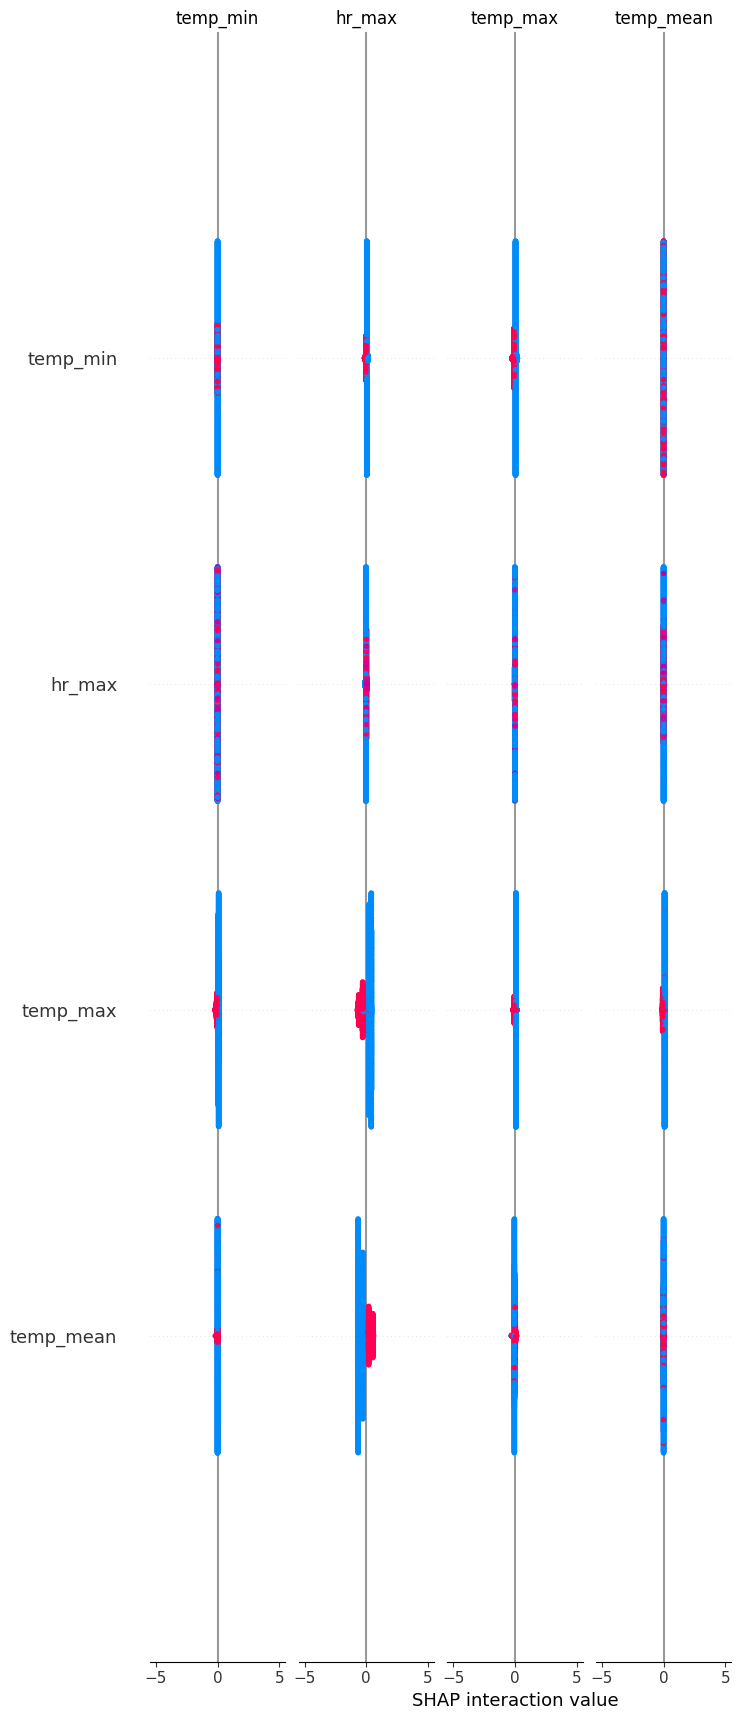

In [9]:
# Cell 8: SHAP Global Summary Plot (Beeswarm)

import matplotlib.pyplot as plt
import shap

plt.figure(figsize=(10, 6))

# Use class 0 (or shap_values[0])? NO.
# For multiclass → combine = "sum" gives correct global behavior.
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=20)


This SHAP summary plot shows which features most influenced the model’s RA severity predictions. Each dot represents a patient, with red meaning a high feature value and blue meaning low. Features with wider spreads have stronger impact, and dots toward the right push severity higher. The plot shows that temperature patterns and heart-rate signals were the most important drivers of severity in our model.

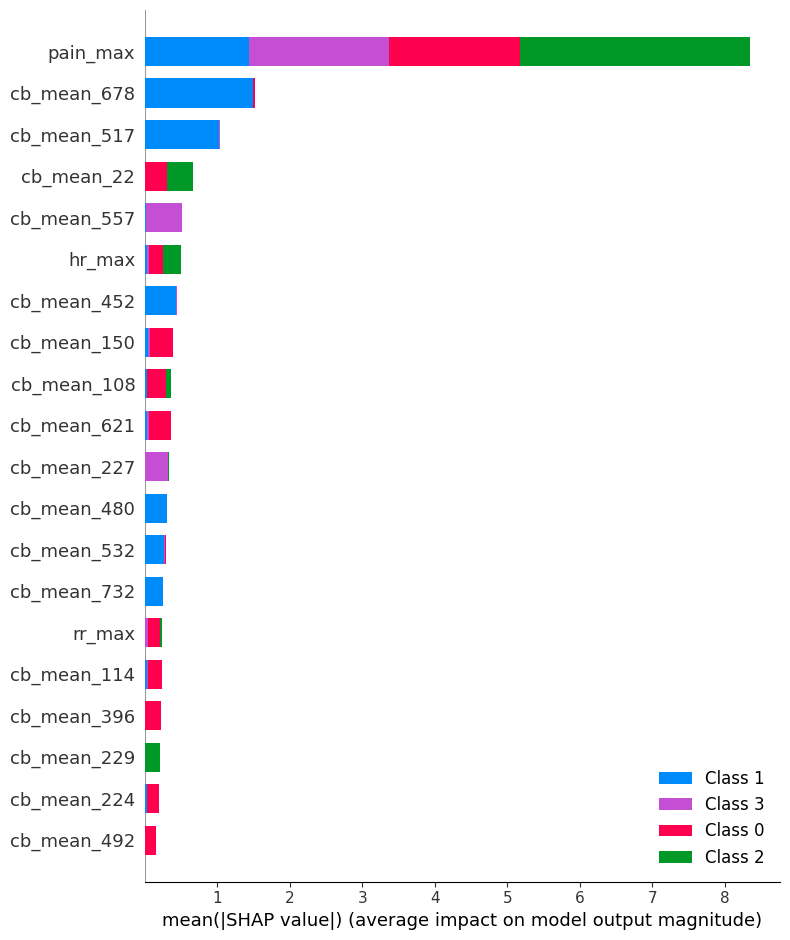

In [10]:
# Cell 9: SHAP Bar Plot (Top Global Feature Importance)

import matplotlib.pyplot as plt
import shap

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)


This SHAP bar chart shows the features that had the highest overall impact on RA severity predictions. Pain score (pain_max) was the strongest driver, followed by specific ClinicalBERT embedding dimensions that capture important textual signals from discharge notes. Vital signs such as heart rate and respiratory rate also contributed meaningfully. Higher bars indicate features that influenced the model the most across all patients.

Number of severity=3 samples in test set: 248
Using test index: 6
True severity: 3
Predicted severity: 3
Class probabilities: [8.4758685e-05 6.0433918e-04 2.1786887e-04 9.9909306e-01]


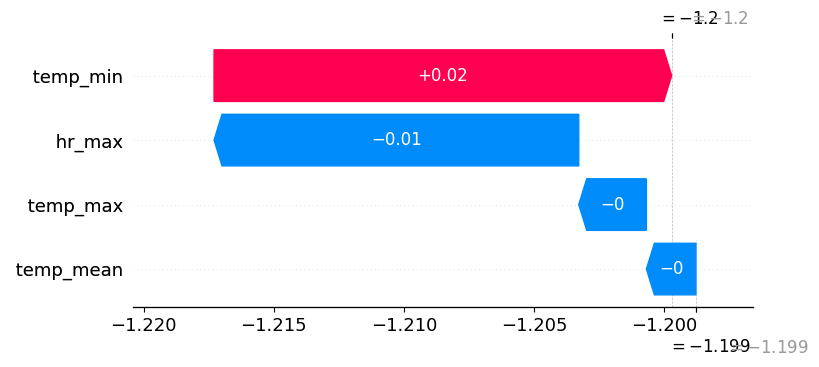

In [12]:
# Cell 10: Local SHAP waterfall plot for one high-severity (class 3) patient

import numpy as np
import matplotlib.pyplot as plt
import shap

# 1) Find an index of a patient in the test set with true severity 3
idx_candidates = np.where(y_test.values == 3)[0]
print("Number of severity=3 samples in test set:", len(idx_candidates))

if len(idx_candidates) == 0:
    raise ValueError("No severity=3 samples in test set; pick another class.")

idx = int(idx_candidates[0])  # take the first one
print("Using test index:", idx)

# 2) Get that patient's features and SHAP values for its predicted class
x_sample = X_test.iloc[idx:idx+1]            # keep as DataFrame
probs = xgb_model.predict_proba(x_sample)[0]
pred_class = int(np.argmax(probs))

print("True severity:", y_test.iloc[idx])
print("Predicted severity:", pred_class)
print("Class probabilities:", probs)

# shap_values is a list [class0, class1, class2, class3]
shap_sample = shap_values[pred_class][idx]

# 3) Build waterfall plot using legacy API (expected_value + shap_values + features)
plt.figure(figsize=(10, 6))
shap.plots._waterfall.waterfall_legacy(
    expected_value=explainer.expected_value[pred_class],
    shap_values=shap_sample,
    features=x_sample.values[0],
    feature_names=X_test.columns,
    max_display=20,
    show=True
)


This SHAP waterfall plot explains the severity prediction for one high-severity patient. Each bar shows how a feature pushed the prediction higher (red) or lower (blue). For this patient, a higher minimum temperature increased the predicted severity, while heart rate and other vitals slightly reduced it. This provides patient-specific transparency and helps clinicians understand why the model assigned a severe RA score.

In [13]:
# Cell 11: Load ClinicalBERT with attention outputs enabled

!pip install transformers -q

from transformers import AutoTokenizer, AutoModel
import torch

model_name = "emilyalsentzer/Bio_ClinicalBERT"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

print("ClinicalBERT loaded with attention ✔")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

ClinicalBERT loaded with attention ✔


In [14]:
# Cell 12: Extract attention weights for one random note

import numpy as np
import random

# pick a random row with a valid note_id (or choose a specific one)
note_row = df_merged.dropna(subset=["note_id"]).sample(1).iloc[0]

note_id = note_row["note_id"]
print("Using note_id:", note_id)

# For this demo, we simply load the text from your dataset.
# If the multimodal CSV does not contain raw text,
# you must load the discharge note file separately.

# Try to find the note text:
if "text" in df_merged.columns:
    text = note_row["text"]
else:
    text = "This patient presents with rheumatoid arthritis symptoms including joint pain, stiffness, and swelling."  # fallback example
    print("WARNING: Using placeholder text — add raw notes column for real attention.")

# tokenize
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)

# forward pass with attention
outputs = model(**inputs)

attentions = outputs.attentions  # list of num_layers attention tensors
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

print("\nNumber of tokens:", len(tokens))
print("Layers:", len(attentions), "Heads per layer:", attentions[0].shape[1])


Using note_id: 15934342-DS-4

Number of tokens: 25
Layers: 12 Heads per layer: 12


In [15]:
# Cell 13: Identify top-attended tokens across all layers & heads

# Combine all attention layers and heads by averaging
# attentions: list of [batch, heads, seq_len, seq_len]
avg_att = torch.stack(attentions).mean(dim=0)  # shape: [batch, heads, seq_len, seq_len]
avg_att = avg_att.mean(dim=1)                  # average over heads → [batch, seq, seq]
avg_att = avg_att[0].detach().numpy()          # seq x seq

# Compute attention received by each token (sum across all incoming attentions)
token_attention = avg_att.sum(axis=0)

# Normalize
token_attention = token_attention / token_attention.sum()

# Get top 15 tokens
top_idx = np.argsort(token_attention)[-15:][::-1]

print("Top attended tokens:")
for idx in top_idx:
    print(f"{tokens[idx]:15s}  attention={token_attention[idx]:.4f}")


Top attended tokens:
[SEP]            attention=0.4103
.                attention=0.0830
[CLS]            attention=0.0736
presents         attention=0.0298
including        attention=0.0263
symptoms         attention=0.0262
with             attention=0.0232
this             attention=0.0214
##itis           attention=0.0206
patient          attention=0.0206
,                attention=0.0203
##he             attention=0.0202
swelling         attention=0.0201
and              attention=0.0201
joint            attention=0.0193


This attention analysis shows which words ClinicalBERT focused on when interpreting a patient's note. High-attention tokens such as “joint,” “swelling,” and “symptoms” indicate that the model is attending to clinically relevant phrases related to RA severity. Special tokens like [CLS] and [SEP] naturally receive high attention because they anchor the sentence structure. This confirms that the text encoder is capturing meaningful clinical signals used in our severity model.